In [49]:
from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

{'CodeCell': {'cm_config': {'autoCloseBrackets': False}}}

# Определение перспективного тарифа для телеком-компании

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Предварительный-анализ-и-обработка" data-toc-modified-id="Предварительный-анализ-и-обработка-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Предварительный анализ и обработка</a></span></li><li><span><a href="#Создание-новых-столбцов" data-toc-modified-id="Создание-новых-столбцов-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Создание новых столбцов</a></span></li></ul></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Проверка-гипотез" data-toc-modified-id="Проверка-гипотез-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Проверка гипотез</a></span><ul class="toc-item"><li><span><a href="#Cредняя-выручка-с-пользователей-тарифов-«Ультра»-и-«Смарт»-различаются" data-toc-modified-id="Cредняя-выручка-с-пользователей-тарифов-«Ультра»-и-«Смарт»-различаются-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Cредняя выручка с пользователей тарифов «Ультра» и «Смарт» различаются</a></span></li><li><span><a href="#Cредняя-выручка-c-пользователей-из-Москвы-отличается-от-выручки-c-пользователей-из-других-регионов." data-toc-modified-id="Cредняя-выручка-c-пользователей-из-Москвы-отличается-от-выручки-c-пользователей-из-других-регионов.-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Cредняя выручка c пользователей из Москвы отличается от выручки c пользователей из других регионов.</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

## Предобработка данных

### Предварительный анализ и обработка

In [50]:
import pandas as pd

dfnames = ['users','internet','messages','tariffs','calls']
for name in dfnames:
    exec(f'{name} = pd.read_csv("/datasets/{name}.csv")')

In [51]:
for name in dfnames:
    print(name)
    exec(f'print({name})')
    exec(f'{name}.info()')
    print('_______________________________________________________')

users
     user_id  age  churn_date         city first_name  last_name    reg_date  \
0       1000   52         NaN    Краснодар     Рафаил  Верещагин  2018-05-25   
1       1001   41         NaN       Москва       Иван       Ежов  2018-11-01   
2       1002   59         NaN  Стерлитамак    Евгений  Абрамович  2018-06-17   
3       1003   23         NaN       Москва      Белла   Белякова  2018-08-17   
4       1004   68         NaN  Новокузнецк    Татьяна   Авдеенко  2018-05-14   
..       ...  ...         ...          ...        ...        ...         ...   
495     1495   65         NaN      Иркутск  Авксентий      Фокин  2018-08-28   
496     1496   36         NaN      Вологда     Трифон     Блохин  2018-01-27   
497     1497   32         NaN    Челябинск   Каролина     Агеева  2018-10-09   
498     1498   68  2018-10-25  Владикавказ   Всеволод    Акимчин  2018-07-19   
499     1499   35         NaN        Пермь     Гектор   Корнилов  2018-09-27   

    tariff  
0    ultra  
1    sm

В таблице internet нужно убрать лишнюю колонку "Unnamed: 0"

In [52]:
internet = internet.drop('Unnamed: 0', axis=1)

В большинстве таблиц есть колонка "id", содержимое которой имеет вид "номер пользователя_номер сессии", что совершенно не требуется, поскольку номер пользователя есть в другой колонке. В данных можно оставить только номер сессии, а тип данных перевести в int, а сами колонки переименовать во избежание путаницы, поскольку таблицы будут объеденены.

In [53]:
old_names = ['internet','messages','calls']
#посольку число символов в user_id фиксированное, то можно обойтись простым срезом
for old_name in old_names:
    exec(f"{old_name}['id'] = {old_name}['id'].apply(lambda x: x[5:]).astype('int64', errors='ignore')")

In [54]:
new_names = ['session_id', 'message_id', 'call_id']
for old_name, new_name in zip(old_names,new_names):
    #exec(f"{name}.rename(columns=\{'id': '{new_name}'\}, inplace=True)")
    exec("%s.rename(columns={'id': '%s'}, inplace=True)" % (old_name,new_name))

Даты с вида все однотипные, лекго читаются, похожи на формат datetime, но не являются им. Требуется конвертирование.

In [55]:
for x in ["users['churn_date']","internet['session_date']","messages['message_date']","calls['call_date']"]:
    exec(f"{x} = pd.to_datetime({x},format='%Y-%m-%d')")

Проверяем столбец с населёнными пунктами на наличие неявных дубликатов:

In [56]:
print(users['city'].sort_values().unique())

['Архангельск' 'Астрахань' 'Балашиха' 'Барнаул' 'Белгород' 'Брянск'
 'Владивосток' 'Владикавказ' 'Владимир' 'Волгоград' 'Волжский' 'Вологда'
 'Воронеж' 'Грозный' 'Екатеринбург' 'Иваново' 'Ижевск' 'Иркутск' 'Казань'
 'Калининград' 'Калуга' 'Кемерово' 'Киров' 'Кострома' 'Краснодар'
 'Красноярск' 'Курган' 'Курск' 'Липецк' 'Магнитогорск' 'Махачкала'
 'Москва' 'Мурманск' 'Набережные Челны' 'Нижневартовск' 'Нижний Новгород'
 'Нижний Тагил' 'Новокузнецк' 'Новороссийск' 'Новосибирск' 'Омск'
 'Оренбург' 'Орёл' 'Пенза' 'Пермь' 'Петрозаводск' 'Подольск'
 'Ростов-на-Дону' 'Рязань' 'Самара' 'Санкт-Петербург' 'Саранск' 'Саратов'
 'Севастополь' 'Смоленск' 'Сочи' 'Ставрополь' 'Стерлитамак' 'Сургут'
 'Тамбов' 'Тверь' 'Тольятти' 'Томск' 'Тула' 'Тюмень' 'Улан-Удэ'
 'Ульяновск' 'Уфа' 'Хабаровск' 'Химки' 'Чебоксары' 'Челябинск' 'Череповец'
 'Чита' 'Якутск' 'Ярославль']


В городах дубликаты отсутствуют. Убираем возможные явные  дубликаты во всех таблицах.

In [57]:
for name in dfnames:
    exec(f'{name} = {name}.drop_duplicates()')

### Создание новых столбцов
Для выполнения задания потребуется группировки по месяцам.

In [58]:
#наставники против использования exec()
calls['month_year'] = calls['call_date'].dt.to_period('M')
internet['month_year'] = internet['session_date'].dt.to_period('M')
messages['month_year'] = messages['message_date'].dt.to_period('M')

Рассчитываем количество сделанных звонков и израсходованных минут разговора по месяцам,
количество отправленных сообщений по месяцам,
объем израсходованного интернет-трафика по месяцам для каждого пользователя, объединяем всё в одну таблицу:

In [59]:
df = calls.groupby(['user_id','month_year']).agg({'duration': ['sum','count']})
df.columns = ['minutes_month', 'calls_month']

In [60]:
df = pd.merge(df,messages.groupby(['user_id','month_year'])['message_id'].count(), left_index = True, right_index = True, how = 'outer')

In [61]:
df = pd.merge(df,internet.groupby(['user_id','month_year'])['mb_used'].sum(), left_index = True, right_index = True, how = 'outer')

In [62]:
df.columns = ['minutes_month', 'calls_month', 'messages', 'traffic']

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 2018-05) to (1499, 2018-12)
Data columns (total 4 columns):
minutes_month    3174 non-null float64
calls_month      3174 non-null float64
messages         2717 non-null float64
traffic          3203 non-null float64
dtypes: float64(4)
memory usage: 114.0 KB


Рассмотрим пользователей, которые прекратили пользоваться тарифом.

In [64]:
users_quit = users[pd.notnull(users['churn_date'])]
users_quit

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
19,1019,63,2018-10-05,Томск,Игнатий,Круглов,2018-05-16,ultra
20,1020,59,2018-12-18,Чита,Тала,Костина,2018-10-22,smart
34,1034,66,2018-11-21,Вологда,Святослав,Бондарев,2018-08-26,smart
50,1050,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra
51,1051,37,2018-10-14,Москва,Кристина,Сомова,2018-05-28,smart
56,1056,73,2018-10-14,Иркутск,Радислав,Артемьев,2018-04-13,smart
62,1062,24,2018-12-09,Москва,Александр,Коршунов,2018-11-16,smart
63,1063,45,2018-12-11,Тула,Таира,Климова,2018-04-12,ultra
64,1064,55,2018-12-26,Якутск,Динара,Алфеева,2018-03-17,smart
65,1065,53,2018-12-09,Москва,Роза,Игнатова,2018-03-08,smart


Таких пользователей совсем немного относительно общего числа, кроме того, они не повторяются, значит либо пользователь разорвал договор с оператором, либо перешёл на какой-то неуказанный тариф. Посмотрим, была ли активность у этих пользователей после даты прекращения пользования тарифом.

In [65]:
quit_last_active = df.reset_index()[df.reset_index()['user_id'].isin(users_quit['user_id']) & pd.notnull(df.reset_index()['month_year'])].sort_values('month_year', ascending = False).groupby('user_id')['month_year'].first()
users_quit = users_quit.set_index('user_id')
users_quit['last_activity'] = quit_last_active
users_quit

,age,churn_date,city,first_name,last_name,reg_date,tariff,last_activity
user_id,,,,,,,,
1019,63,2018-10-05,Томск,Игнатий,Круглов,2018-05-16,ultra,2018-10
1020,59,2018-12-18,Чита,Тала,Костина,2018-10-22,smart,2018-12
1034,66,2018-11-21,Вологда,Святослав,Бондарев,2018-08-26,smart,2018-11
1050,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra,2018-10
1051,37,2018-10-14,Москва,Кристина,Сомова,2018-05-28,smart,2018-10
1056,73,2018-10-14,Иркутск,Радислав,Артемьев,2018-04-13,smart,2018-10
1062,24,2018-12-09,Москва,Александр,Коршунов,2018-11-16,smart,2018-12
1063,45,2018-12-11,Тула,Таира,Климова,2018-04-12,ultra,2018-12
1064,55,2018-12-26,Якутск,Динара,Алфеева,2018-03-17,smart,2018-12


В данных полностью отсутсвует активность о деятельности пользователей, из-за чего появились пропуски, из-за сломался тип данных datetime, но поскольку данных на выводе не очень много, по ним прекрасно видно, что активности у пользователей не было после прекращения тарифа, значит эту дату можно игнорировать и просто рассчитывать стоимости согласно тарифу из таблицы, но сначала надо округлить трафик и минуты до целых по месяцам, поскольку так рассчитывается стоимость.

In [66]:
import numpy as np
df[['minutes_month','traffic']] = np.ceil(df[['minutes_month','traffic']])
df

minutes_month  calls_month  messages  traffic
user_id month_year                                               
1000    2018-05             151.0         22.0      22.0   2254.0
        2018-06             159.0         43.0      60.0  23234.0
        2018-07             319.0         47.0      75.0  14004.0
        2018-08             390.0         52.0      81.0  14056.0
        2018-09             441.0         58.0      57.0  14569.0
...                           ...          ...       ...      ...
1498    2018-10             233.0         41.0      42.0  20580.0
1499    2018-09              65.0          9.0      11.0   1846.0
        2018-10             430.0         68.0      48.0  17789.0
        2018-11             577.0         74.0      59.0  17964.0
        2018-12             466.0         69.0      66.0  13056.0

[3214 rows x 4 columns]

In [67]:
df = df.reset_index().merge(users[['user_id','tariff', 'city']], on = 'user_id', how = 'left')

In [68]:
df = df.merge(tariffs, left_on = 'tariff', right_on = 'tariff_name', how = 'left').drop(columns = ['tariff_name'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 15 columns):
user_id                  3214 non-null int64
month_year               3214 non-null period[M]
minutes_month            3174 non-null float64
calls_month              3174 non-null float64
messages                 2717 non-null float64
traffic                  3203 non-null float64
tariff                   3214 non-null object
city                     3214 non-null object
messages_included        3214 non-null int64
mb_per_month_included    3214 non-null int64
minutes_included         3214 non-null int64
rub_monthly_fee          3214 non-null int64
rub_per_gb               3214 non-null int64
rub_per_message          3214 non-null int64
rub_per_minute           3214 non-null int64
dtypes: float64(4), int64(8), object(2), period[M](1)
memory usage: 401.8+ KB


В некоторых месяцах отсутствуют значения с сообщениями, звонками и интернет-трафиком, но поскольку в них что-то совершелось, значит тариф в этот месяц точно работал, но пользователь не воспользовался всеми услугами. Такие пропуски нужно заменить нулями.

In [69]:
df = df.fillna({'traffic': 0, 'messages': 0, 'minutes_month': 0, 'calls_month': 0})
df[['traffic','messages','minutes_month','calls_month']] = df[['traffic','messages','minutes_month','calls_month']].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 15 columns):
user_id                  3214 non-null int64
month_year               3214 non-null period[M]
minutes_month            3214 non-null int64
calls_month              3214 non-null int64
messages                 3214 non-null int64
traffic                  3214 non-null int64
tariff                   3214 non-null object
city                     3214 non-null object
messages_included        3214 non-null int64
mb_per_month_included    3214 non-null int64
minutes_included         3214 non-null int64
rub_monthly_fee          3214 non-null int64
rub_per_gb               3214 non-null int64
rub_per_message          3214 non-null int64
rub_per_minute           3214 non-null int64
dtypes: int64(12), object(2), period[M](1)
memory usage: 401.8+ KB


Для рассчётов выручки с пользователя треубется написать функцию. Из описания задания, а конкретно требования подсчитать активность пользователей по календарным месяцам, а не по скользящим, следует, что Мегалайн либо берёт плату за календарный месяц, либо делается допущение, что плата идёт за календарный месяц.

In [70]:
def set_price(row):
    price = row.rub_monthly_fee
    if row.minutes_included < row.minutes_month:
        price += (row.minutes_month - row.minutes_included) * row.rub_per_minute
    if row.messages_included < row.messages:
        price += (row.messages - row.messages_included) * row.rub_per_message
    if row.mb_per_month_included < row.traffic:
        price += (row.traffic - row.mb_per_month_included) * row.rub_per_gb/1024
                
    return round(price, 2)


df['profit'] = df.apply(lambda row: set_price(row), axis = 1)

In [71]:
df

,user_id,month_year,minutes_month,calls_month,messages,traffic,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
0,1000,2018-05,151,22,22,2254,ultra,Краснодар,1000,30720,3000,1950,150,1,1,1950.00
1,1000,2018-06,159,43,60,23234,ultra,Краснодар,1000,30720,3000,1950,150,1,1,1950.00
2,1000,2018-07,319,47,75,14004,ultra,Краснодар,1000,30720,3000,1950,150,1,1,1950.00
3,1000,2018-08,390,52,81,14056,ultra,Краснодар,1000,30720,3000,1950,150,1,1,1950.00
4,1000,2018-09,441,58,57,14569,ultra,Краснодар,1000,30720,3000,1950,150,1,1,1950.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,2018-10,233,41,42,20580,smart,Владикавказ,50,15360,500,550,200,3,3,1569.53
3210,1499,2018-09,65,9,11,1846,smart,Пермь,50,15360,500,550,200,3,3,550.00
3211,1499,2018-10,430,68,48,17789,smart,Пермь,50,15360,500,550,200,3,3,1024.41
3212,1499,2018-11,577,74,59,17964,smart,Пермь,50,15360,500,550,200,3,3,1316.59


Предобработка завершена

## Анализ данных

Рассмотрим средние показания всех пользователей трарифов по месяцам:

In [72]:
df.groupby('tariff')[['traffic','messages','minutes_month']].mean()

,traffic,messages,minutes_month
tariff,,,
smart,16208.873486,33.384029,394.922387
ultra,19469.308629,49.363452,497.547208


Пользователи тарифа в средннем "Ультра" тратят на одну треть больше минут, на половину сообщений, но потребляют всего лишь на 20% больше интернет-траффика, причём до включенных в тариф лимитов далеко по всем показателям.
В Тарифе "Смарт" в среднем идёт перерасход интернет-траффика.

smart traffic cтандартное отклонение: 5869.16534176946
smart traffic дисперсия: 34447101.80902782
ultra traffic cтандартное отклонение: 10082.076020917017
ultra traffic дисперсия: 101648256.8915499


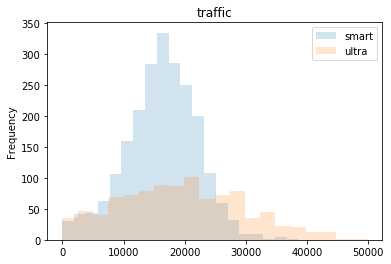

smart messages cтандартное отклонение: 28.221542886898938
smart messages дисперсия: 796.455482917076
ultra messages cтандартное отклонение: 47.78018496610161
ultra messages дисперсия: 2282.9460753948824


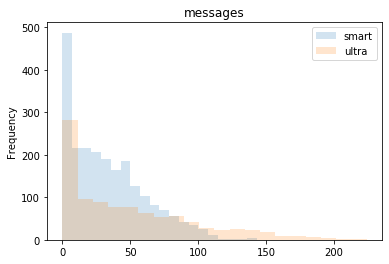

smart minutes_month cтандартное отклонение: 179.93991516598774
smart minutes_month дисперсия: 32378.373069942867
ultra minutes_month cтандартное отклонение: 299.77723718426284
ultra minutes_month дисперсия: 89866.39193382979


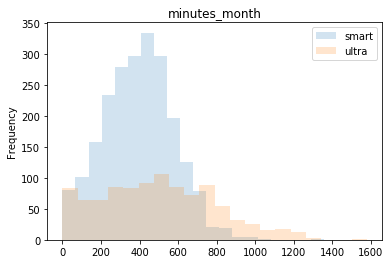

In [73]:
import matplotlib.pyplot as plt
tariff_list = ['smart','ultra']
items = ['traffic','messages','minutes_month']

        
for item in items:
    for tariff in tariff_list:
        df[df['tariff'] == tariff][item].plot(kind='hist',title=item, alpha = 0.2, label=tariff,legend=True, bins = 20)
        print(tariff, item,'cтандартное отклонение:', np.std(df[df['tariff'] == tariff][item]))
        print(tariff, item,'дисперсия:', np.var(df[df['tariff'] == tariff][item]))
        
        
        
    plt.show()

Распределения потраченных минут и интернет-траффика больше всего похожи на биномиальное, сообщений - геометрическое, потому что сервис потерял популярность из-за интернет-мессенджеров. Пользователи обоих тарифов стараются сильно не привышать лимит в по звонками и траффику, при этом распределения у пользователей "Ультра" куда более рванное, скорее всего, полотму что пользователи меньше следят за минутами и мегабайтами.

## Проверка гипотез

### Cредняя выручка с пользователей тарифов «Ультра» и «Смарт» различаются

Посмотрим, как отличаются графики распределения выручек.

smart
count    2229.000000
mean     1198.113356
std       767.843846
min       550.000000
25%       550.000000
50%       925.590000
75%      1603.200000
max      6543.880000
Name: profit, dtype: float64

ultra
count     985.000000
mean     2059.879614
std       354.901015
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4737.010000
Name: profit, dtype: float64



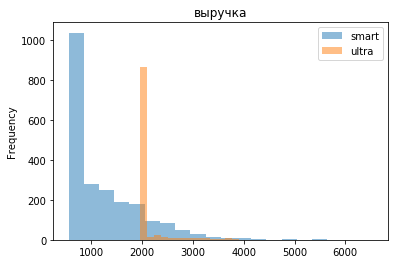

In [74]:
for tariff in tariff_list:
        df[df['tariff'] == tariff]['profit'].plot(kind='hist',title='выручка', alpha = 0.5, label=tariff,legend=True, bins = 20)
        print(tariff)
        print(df[df['tariff'] == tariff]['profit'].describe())
        print()

Подавляющее большнинство пользователей "Ультра" вообще не выходят за пределы предустановленног тарифа. Отличия в выручке видны невооруженным глазом.

Нулевая гипотеза: "средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается". Если нулевая гипотеза будет опровергнута, то противоположный тезис подтвердится. Требуется двусторонний тест, поскольку выручка может быть как больше, так и меньше.

In [75]:
from scipy import stats as st
results = st.ttest_ind(df[df['tariff'] == 'smart']['profit'], df[df['tariff'] == 'ultra']['profit'])

alpha = 0.05

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 4.198314684235501e-213
Отвергаем нулевую гипотезу


Нулевая гипотеза отвержена, следовательно обратное утверждение верно. Средние выручки различаются.

### Cредняя выручка c пользователей из Москвы отличается от выручки c пользователей из других регионов.

Москва
count     611.000000
mean     1485.405597
std       737.633349
min       550.000000
25%       698.820000
50%      1638.250000
75%      1950.000000
max      5043.230000
Name: profit, dtype: float64

другие регионы
count    3214.000000
mean     1462.220314
std       778.014497
min       550.000000
25%       658.000000
50%      1515.095000
75%      1950.000000
max      6543.880000
Name: profit, dtype: float64



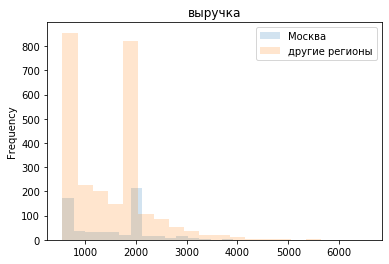

In [76]:
df[df['city'] == 'Москва']['profit'].plot(kind='hist',title='выручка', alpha = 0.2, label='Москва',legend=True, bins = 20)
print('Москва')
print(df[df['city'] == 'Москва']['profit'].describe())
print()
#plt.show()
df[df['city'] != 'Москва']['profit'].plot(kind='hist',title='выручка', alpha = 0.2, label='другие регионы',legend=True, bins = 20)
print('другие регионы')
print(df[df['tariff'] != 'Москва']['profit'].describe())
print()

Распределения выглядит весьма схожими. Так же проверим гипотезу от обратного.

In [77]:
results = st.ttest_ind(df[df['city'] == 'Москва']['profit'], df[df['city'] != 'Москва']['profit'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.41314302417849347
Не получилось отвергнуть нулевую гипотезу


Различие между средними выручками не является значимым, то есть выручки с пользователей из Москвы и других регионов не отличаются.

## Вывод
Наиболее точными результаты можно считать, если оператор на самом деле тарифицирует клиентов по календарным месяцам, в противном случае будет иметь место ошибка, вероятно, малозначимая из-за продолжительности пользования тарифами, поскольку статистика считалась для календарного месяца. Большая часть пользователей не выходит за лимиты своего тарифа, особенно это касается тарифа "Ультра", значительная часть пользователей которого даже не успевает использовать лимиты "Смарт", не говоря уже об "Ултра", при этом платят в среднем в два раза больше. Значительных отличий выручек с пользователей из Москвы и регионов не выявлено. Для "Мегалайн" тариф "Ульта" однозначно выгоднее.